In [11]:
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import matplotlib
import pickle
matplotlib.use('nbagg')
from scripts.tools import *
import numpy as np
import collections
import math
import copy
from sklearn.metrics import confusion_matrix

In [ ]:

invalid_rf = pickle.load(open('./scripts/invalid_rf.sav', 'rb'))


def predict(X):
    invalid_predictions = invalid_rf.predict(X)
    class_predictions = clf.predict(X)
    pred_classes = []
    for inv,_class in zip(invalid_predictions,class_predictions):
        if inv == 'invalid':
            pred_classes.append('invalid')
        else:
            pred_classes.append(_class)
    
    return pred_classes


# def predict(X):
#     # valid_score_distr = [0.21333333333333335, 0.23545454545454553, 0.2651795866799025, 0.2651807228915663, 0.31351107591184874, 0.3445535557634341, 0.3757644812229298, 0.43702938375988665, 0.47489680328240436, 0.5250216389488874, 0.5841523093106213, 0.6431839335774511, 0.6628399585627003, 0.746936122097882, 0.8229870129870132, 0.8437837837837837, 0.881102256680904, 0.9605, 0.9872727272727274, 1.0]
#     invalid_score_dist = [0.21333333333333335, 0.23545454545454553, 0.25218856601389766, 0.24381578947368418, 0.2691051960278174, 0.2864327485380117, 0.30397336243324213, 0.3144550833152309, 0.3254603462146956, 0.32779965806722583, 0.34266385634223634, 0.33327569720919137, 0.3609318201261795, 0.38249999999999995, 0.43, 0, 0, 0, 0, 0] 
    
#     classes = clf.classes_

#     prob_predictions = clf.predict_proba(X)
#     pred_classes = []
#     for pred in prob_predictions:
#         pred = list(pred)

#         n_zeros = pred.count(0)

#         # if max(pred) <= 0.43:
#         if max(pred) <= 0.43 and max(pred) <= invalid_score_dist[n_zeros]:
#             pred_classes.append('invalid')
#         else:
#             i = pred.index(max(pred))
#             pred_classes.append(classes[i])
            
#     return pred_classes

def cap_dataset(X,Y,limit):
    class_limits = {y:0 for y in list(set(Y))}

    tmp_X = []
    tmp_Y = []

    for x,y in zip(X,Y):
        if class_limits[y] < limit:
            tmp_X.append(x)
            tmp_Y.append(y)
            class_limits[y] += 1

    return tmp_X,tmp_Y


def show_wrongly_predicted(X,Y,clf):

    predictions = clf.predict(X)

    wrong_pred = {}
    tot = {}
    for pred,y in zip(predictions,Y):
        tot.setdefault(y,0)
        tot[y] += 1
        if pred != y:
            wrong_pred.setdefault(y,0)
            wrong_pred[y] += 1

    # n times wrongly classified
    for y in wrong_pred:
        wa = wrong_pred[y]
        print(f'* wrongly predicted {y}: {wa}/{tot[y]}:  {int(round(wa/tot[y],3)*100)}%')

In [14]:
df = pd.read_csv('./data/train.csv')
X = df.values
X = [x[:-1] for x in X] # remove cuisine
Y = list(df['cuisine'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05,random_state=0)
clf = RandomForestClassifier(random_state=0, n_jobs=-2,class_weight='balanced_subsample')
clf.fit(X_train,Y_train)

custom_clf = copy.deepcopy(clf)
custom_clf.predict = predict



In [ ]:
#scores on train set
scores = cross_val_score(clf, X, Y, cv=5,n_jobs=27)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
scores = cross_val_score(custom_clf, X, Y, cv=5,n_jobs=27)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

/home/ubuntu/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0.71 accuracy with a standard deviation of 0.00


/home/ubuntu/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0.71 accuracy with a standard deviation of 0.00


In [15]:
INPUT_PATH = './data/test.csv'
# INPUT_PATH = './data/cleaned_test.csv'

df = pd.read_csv(INPUT_PATH)

print(len(df.columns))

X = df.values
print(f'n samples: {len(X)}')
X = [x[:-1] for x in X] # remove cuisine
Y = list(df['cuisine'])
Y = [y.lower() for y in Y]

show_class_ratio(Y)

6682
n samples: 7070
* invalid 3557
* indian 1984
* mexican 427
* italian 421
* chinese 138
* french 134
* thai 108
* filipino 78
* greek 53
* spanish 42
* japanese 37
* irish 32
* russian 21
* vietnamese 11
* korean 9
* moroccan 7
* brazilian 6
* british 5


In [16]:
X,Y = cap_dataset(X,Y,500) # cap to balance data set to get more correct view of accuracy
show_class_ratio(Y)

* indian 500
* invalid 500
* mexican 427
* italian 421
* chinese 138
* french 134
* thai 108
* filipino 78
* greek 53
* spanish 41
* japanese 37
* irish 32
* russian 20
* vietnamese 11
* korean 9
* moroccan 7
* brazilian 6
* british 5


In [ ]:
def zero_distr(X:list,Y:list,invalid:bool):
    prob_pred = custom_clf.predict_proba(X)
    class_pred = custom_clf.predict(X)

    zeros = []

    for prob,_class in zip(prob_pred,class_pred):
        prob = list(prob)
        count = prob.count(0)
        
        if invalid and _class == 'invalid':
            zeros.append(count)

        elif not invalid and _class != 'invlaid':
            zeros.append(count)
             
    counts = {c:0 for c in range(0,20)}
    counts = {c:zeros.count(c) for c in counts}

    n_zeros = list(counts.keys())
    n_zeros = [str(n) for n in n_zeros]
    n_occurances = list(counts.values())

    
    return zeros,n_zeros,n_occurances


def max_score_distr(X:list,Y:list,invalid:bool):
    prob_pred = custom_clf.predict_proba(X)
    class_pred = custom_clf.predict(X)

    zeros = {count:[] for count in range(0,20)}
    for prob,_class in zip(prob_pred,class_pred):
        
        prob = list(prob)
        count = prob.count(0)

        if invalid and _class == 'invalid':
            zeros[count].append(max(prob))

        elif not invalid and _class != 'invlaid':
            zeros[count].append(max(prob))

    tmp = {count:np.mean(zeros[count]) for count in zeros}
    for key in tmp:
        if math.isnan(tmp[key]):
            tmp[key] = 0


    #order mean max score by number of zeros
    distr = collections.OrderedDict(sorted(tmp.items()))

    return list(distr.values())


In [ ]:
valid_zeros,valid_n_zeros,valid_n_occurances = zero_distr(X,Y,invalid=False)

valid_score_distr = max_score_distr(X,Y,invalid=False)

invalid_zeros,invalid_n_zeros,invalid_n_occurances = zero_distr(X,Y,invalid=True)
invalid_score_distr = max_score_distr(X,Y,invalid=True)


# valid_score_distr = [0.21333333333333335, 0.23545454545454553, 0.2651795866799025, 0.2651807228915663, 0.31351107591184874, 0.3445535557634341, 0.3757644812229298, 0.43702938375988665, 0.47489680328240436, 0.5250216389488874, 0.5841523093106213, 0.6431839335774511, 0.6628399585627003, 0.746936122097882, 0.8229870129870132, 0.8437837837837837, 0.881102256680904, 0.9605, 0.9872727272727274, 1.0]
# invalid_score_dist = [0.21333333333333335, 0.23545454545454553, 0.25218856601389766, 0.24381578947368418, 0.2691051960278174, 0.2864327485380117, 0.30397336243324213, 0.3144550833152309, 0.3254603462146956, 0.32779965806722583, 0.34266385634223634, 0.33327569720919137, 0.3609318201261795, 0.38249999999999995, 0.43, 0, 0, 0, 0, 0]


/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>

Valid
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
[3, 11, 42, 83, 144, 225, 287, 282, 285, 293, 238, 208, 153, 100, 77, 37, 29, 20, 11, 1]
mean=8.34954527481218
avg=8.34954527481218
ev=9.633642735366527
std=3.274390001843098
[6.359252733523428, 12.908032737209625]

Invalid
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
[1, 6, 24, 41, 66, 84, 112, 70, 65, 51, 23, 12, 11, 2, 1, 0, 0, 0, 0, 0]
mean=6.214411247803163
avg=6.214411247803163
ev=7.140837104072419
std=2.39941477478472
[4.7414223292876985, 9.540251878857138]


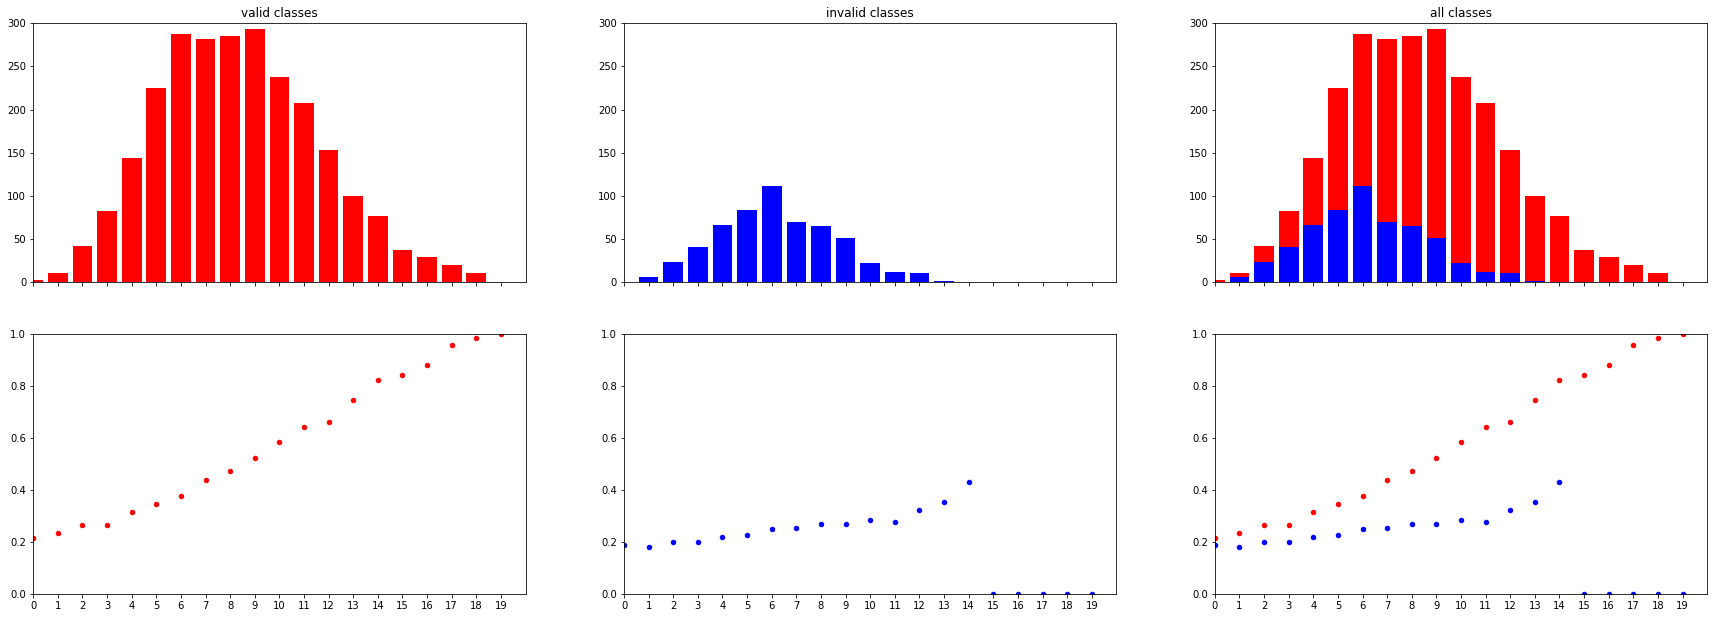

In [ ]:
matplotlib.use('nbagg')

fig, ax = plt.subplots(2,3,sharex=True)
fig.set_size_inches(30, 10.5)

ax[0][0].bar(valid_n_zeros,valid_n_occurances,color='red')
ax[0][0].set_title('valid classes')
ax[1][0].scatter(list(range(0,20)),valid_score_distr,s=20,color='red')

ax[0][1].bar(invalid_n_zeros,invalid_n_occurances,color='blue')
ax[0][1].set_title('invalid classes')
ax[1][1].scatter(list(range(0,20)),invalid_score_distr,s=20,color='blue')


ax[0][2].bar(valid_n_zeros,valid_n_occurances,color='red')
ax[0][2].set_title('valid classes')
ax[0][2].bar(invalid_n_zeros,invalid_n_occurances,color='blue')
ax[0][2].set_title('all classes')
ax[1][2].scatter(list(range(0,20)),valid_score_distr,s=20,color='red')
ax[1][2].scatter(list(range(0,20)),invalid_score_distr,s=20,color='blue')

for i in range(3):
    ax[0][i].set_ylim([0,300])
    ax[1][i].set_ylim([0,1])
    ax[0][i].set_xlim([0,20])
    ax[1][i].set_xlim([0,20])



print('Valid')
print(valid_n_zeros)
print(valid_n_occurances)
print(f'mean={np.mean(valid_zeros)}')
print(f'avg={np.average(valid_zeros)}')

tot = sum(valid_zeros)
ev = sum([(v/tot)*v for v in valid_zeros])
print(f'ev={ev}')
std = np.std(valid_zeros)
print(f'std={std}')
print([ev-std,ev+std])

print('\nInvalid')
print(invalid_n_zeros)
print(invalid_n_occurances)
print(f'mean={np.mean(invalid_zeros)}')
print(f'avg={np.average(invalid_zeros)}')

tot = sum(invalid_zeros)
ev = sum([(v/tot)*v for v in invalid_zeros])
print(f'ev={ev}')
std = np.std(invalid_zeros)
print(f'std={std}')
print([ev-std,ev+std])

plt.show()

* n of occurances of zeros grouped by invalid and valid
* max score for each number of zeros grouped by invalid and valid


In [ ]:
def calc_Expectation(a, n):
     
    # variable prb is for probability
    # of each element which is same for
    # each element
    prb = 1 / n
     
    # calculating expectation overall
    sum = 0
    for i in range(0, n):
        sum += (a[i] * prb)
         
    # returning expectation as sum
    return float(sum)

print(calc_Expectation(valid_zeros,len(valid_zeros)))

8.349545274812249


In [17]:

scores = cross_val_score(clf, X, Y, cv=5,n_jobs=27)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(custom_clf, X, Y, cv=5,n_jobs=27)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.63 accuracy with a standard deviation of 0.02
0.63 accuracy with a standard deviation of 0.02


In [19]:
show_wrongly_predicted(X,Y,clf)
print('\n')
custom_clf.predict = predict
show_wrongly_predicted(X,Y,custom_clf)

* wrongly predicted invalid: 500/500:  100%
* wrongly predicted indian: 65/500:  13%
* wrongly predicted chinese: 49/138:  35%
* wrongly predicted french: 106/134:  79%
* wrongly predicted mexican: 58/427:  13%
* wrongly predicted italian: 107/421:  25%
* wrongly predicted japanese: 18/37:  48%
* wrongly predicted irish: 19/32:  59%
* wrongly predicted thai: 43/108:  39%
* wrongly predicted moroccan: 3/7:  42%
* wrongly predicted british: 5/5:  100%
* wrongly predicted brazilian: 4/6:  66%
* wrongly predicted greek: 21/53:  39%
* wrongly predicted filipino: 21/78:  26%
* wrongly predicted spanish: 18/42:  42%
* wrongly predicted vietnamese: 4/11:  36%
* wrongly predicted korean: 5/9:  55%
* wrongly predicted russian: 14/21:  66%




Process LokyProcess-181:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
    with worker_exit_lock:
  File "/home/ubuntu/.local/lib/python3.8/site-packages/joblib/externals/loky/backend/synchronize.py", line 104, in __enter__
    return self._semlock.acquire()
KeyboardInterrupt


KeyboardInterrupt: 